In [6]:
import numpy as np
import os
import tensorflow as tf
import math
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense,SimpleRNN,Embedding,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [7]:
maotai = pd.read_csv('./SH600519.csv')
# 前（2426 -300 = 2126）天的开盘价作为训练集，
# 表格从0开始记数，2：3是提取【2：3)列
training_set = maotai.iloc[0:2426 -300,2:3].values
# 后300天开盘价作为测试集
test_set =maotai.iloc[2426-300:,2:3].values

# 归一化到0~1之间
sc = MinMaxScaler(feature_range=(0,1))
# 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
# fit_transform()的作用就是先拟合数据，然后转化它将其转化为标准形式。
train_set_scaled = sc.fit_transform(training_set)
# 利用训练集的属性对测试集进行归一化
# tranform()的作用是通过找中心和缩放等实现标准化。
test_set = sc.transform(test_set)
'''们在训练集上调用fit_transform()，其实找到了均值μ和方差σ^2，即我们已经找到了转换规则，我们把这个规则利用在训练集上，同样，
我们可以直接将其运用到测试集上（甚至交叉验证集），所以在测试集上的处理，我们只需要标准化数据而不需要再次拟合数据'''

'们在训练集上调用fit_transform()，其实找到了均值μ和方差σ^2，即我们已经找到了转换规则，我们把这个规则利用在训练集上，同样，\n我们可以直接将其运用到测试集上（甚至交叉验证集），所以在测试集上的处理，我们只需要标准化数据而不需要再次拟合数据'

In [8]:
x_train = []
y_train = []
x_test = []
y_test = []

# 提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签
# 共构建2426 - 300 = 2066组数据
for i in range(60,len(train_set_scaled)):
    x_train.append(train_set_scaled[i-60:i,0])
    y_train.append(train_set_scaled[i,0])
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
x_train,y_train = np.array(x_train),np.array(y_train)

# 此处把整个数据集送入，送入样本数等于x_train[0]即60个开盘价，预测出第61天的开盘价
# 循环核时间展开步数是60
# 单个时间步送入特征是某一天的开盘价，只有一个数据，故单个时间步输入特征个数是1
x_train = np.reshape(x_train,(x_train.shape[0],60,1))

# 测试集 300 -60组测试数据 
for i in range(60,len(test_set)):
    x_test.append(test_set[i - 60 : i, 0])
    y_test.append(test_set[i,0])
x_test, y_test = np.array(x_test),np.array(y_test)
x_test = np.reshape(x_test,(x_test.shape[0],60,1))

In [9]:
model = Sequential([
    # 80个记忆体，每个时间步推送ht给下一层
    SimpleRNN(80,return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])


In [10]:
# 改应用只观测loss数值，不观测准确率，所以删去metrics，一会再每个epoch只显示los值
model.compile(optimizer=Adam(0.001),loss='mean_squared_error')

In [11]:
checkpoint_save_path = "./checkpoint/stock.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print("-----load the model-----")
    model.load_weights(checkpoint_save_path)


In [13]:
cp_callkack = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                monitor='val_loss')
history = model.fit(x_train,y_train,batch_size=64,epochs=50,
                    validation_data=(x_test,y_test),validation_freq=1,
                   callbacks=[cp_callkack])
model.summary()

Train on 2066 samples, validate on 240 samples
Epoch 1/50
2066/2066 [==============================] - 3s 1ms/sample - loss: 0.0681 - val_loss: 0.0406
Epoch 2/50
2066/2066 [==============================] - 1s 519us/sample - loss: 0.0197 - val_loss: 0.0402
Epoch 3/50
2066/2066 [==============================] - 1s 581us/sample - loss: 0.0113 - val_loss: 0.0079
Epoch 4/50
2066/2066 [==============================] - 1s 526us/sample - loss: 0.0083 - val_loss: 0.0080
Epoch 5/50
2066/2066 [==============================] - 1s 548us/sample - loss: 0.0071 - val_loss: 0.0125
Epoch 6/50
2066/2066 [==============================] - 1s 552us/sample - loss: 0.0059 - val_loss: 0.0044
Epoch 7/50
2066/2066 [==============================] - 1s 519us/sample - loss: 0.0050 - val_loss: 0.0048
Epoch 8/50
2066/2066 [==============================] - 1s 550us/sample - loss: 0.0043 - val_loss: 0.0029
Epoch 9/50
2066/2066 [==============================] - 1s 517us/sample - loss: 0.0041 - val_loss: 0.0016
E

In [16]:
with open("./weights.txxt","w") as f:
    for v in model.trainable_variables:
        f.writelines(str(v.name))
        f.writelines(str(v.shape))
        f.writelines(str(v.numpy()))


In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

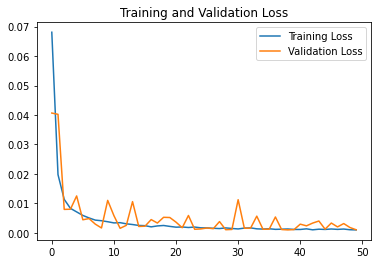

In [17]:
plt.plot(loss,label="Training Loss")
plt.plot(val_loss,label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

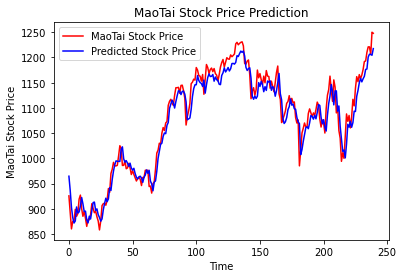

In [18]:
# predict
# 对测试集输入数据进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原 --- 从（0~1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原
real_stock_price = sc.inverse_transform(test_set[60:])
plt.plot(real_stock_price,label="MaoTai Stock Price",color='red')
plt.plot(predicted_stock_price,label="Predicted Stock Price",color='blue')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel("Time")
plt.ylabel("MaoTai Stock Price")
# plt.legend（）函数主要的作用就是给图加上图例
plt.legend()
plt.show()

In [20]:
# 模型预测效果量化
# 均方误差
mse = mean_squared_error(predicted_stock_price,real_stock_price)
# 均方根误差
rmse = math.sqrt(mean_squared_error(predicted_stock_price,real_stock_price))
# 平均绝对误差
mae = mean_absolute_error(predicted_stock_price,real_stock_price)
print("均方误差：%.6f" % mse)
print("均方根误差：%.6f" % rmse)
print("平均绝对误差：%.6f" % mae)

均方误差：503.211814
均方根误差：22.432383
平均绝对误差：17.888682
